In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Okt
import pandas as pd
import tensorflow as tf
import enum
import os
import re
from sklearn.model_selection import train_test_split

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

#PATH = 'data_in/ChatbotData.csv'
PATH = 'data_in/ChatBotData.csv_short'
VOCAB_PATH = 'data_in/vocabulary.txt'

MAX_SEQUENCE = 10

## 데이터 불러오기

In [3]:
def load_data(path):
    # 판다스를 통해서 데이터를 불러온다.
    data_df = pd.read_csv(path, header=0)
    # 질문과 답변 열을 가져와 question과 answer에 넣는다.
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer

In [4]:
inputs, outputs = load_data(PATH)

## 토크나이징과 어휘사전 생성

In [5]:
def data_tokenizer(data):
    # 토크나이징 해서 담을 배열 생성
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])"
        # 위 필터와 같은 값들을 정규화 표현식을
        # 통해서 모두 "" 으로 변환 해주는 부분이다.
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)
    # 토그나이징과 정규표현식을 통해 만들어진
    # 값들을 넘겨 준다.
    return [word for word in words if word]

def load_vocabulary(path, vocab_path):
    # 사전을 담을 배열 준비한다.
    vocabulary_list = []
    # 사전을 구성한 후 파일로 저장 진행한다.
    # 그 파일의 존재 유무를 확인한다.
    if not os.path.exists(vocab_path):
        # 이미 생성된 사전 파일이 존재하지 않으므로
        # 데이터를 가지고 만들어야 한다.
        # 그래서 데이터가 존재 하면 사전을 만들기 위해서
        # 데이터 파일의 존재 유무를 확인한다.
        if (os.path.exists(path)):
            # 데이터가 존재하니 판단스를 통해서
            # 데이터를 불러오자
            data_df = pd.read_csv(path, encoding='utf-8')
            # 판다스의 데이터 프레임을 통해서
            # 질문과 답에 대한 열을 가져 온다.
            question, answer = list(data_df['Q']), list(data_df['A'])
#             if DEFINES.tokenize_as_morph:  # 형태소에 따른 토크나이져 처리
#                 question = prepro_like_morphlized(question)
#                 answer = prepro_like_morphlized(answer)
            data = []
            # 질문과 답변을 extend을
            # 통해서 구조가 없는 배열로 만든다.
            data.extend(question)
            data.extend(answer)
            # 토큰나이져 처리 하는 부분이다.
            words = data_tokenizer(data)
            # 공통적인 단어에 대해서는 모두
            # 필요 없으므로 한개로 만들어 주기 위해서
            # set해주고 이것들을 리스트로 만들어 준다.
            words = list(set(words))
            # 데이터 없는 내용중에 MARKER를 사전에
            # 추가 하기 위해서 아래와 같이 처리 한다.
            # 아래는 MARKER 값이며 리스트의 첫번째 부터
            # 순서대로 넣기 위해서 인덱스 0에 추가한다.
            # PAD = "<PADDING>"
            # STD = "<START>"
            # END = "<END>"
            # UNK = "<UNKNWON>"
            words[:0] = MARKER
        # 사전을 리스트로 만들었으니 이 내용을
        # 사전 파일을 만들어 넣는다.
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    # 사전 파일이 존재하면 여기에서
    # 그 파일을 불러서 배열에 넣어 준다.
    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    # 배열에 내용을 키와 값이 있는
    # 딕셔너리 구조로 만든다.
    char2idx, idx2char = make_vocabulary(vocabulary_list)
    # 두가지 형태의 키와 값이 있는 형태를 리턴한다.
    # (예) 단어: 인덱스 , 인덱스: 단어)
    return char2idx, idx2char, len(char2idx)


def make_vocabulary(vocabulary_list):
    # 리스트를 키가 단어이고 값이 인덱스인
    # 딕셔너리를 만든다.
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}
    # 리스트를 키가 인덱스이고 값이 단어인
    # 딕셔너리를 만든다.
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}
    # 두개의 딕셔너리를 넘겨 준다.
    return char2idx, idx2char

In [6]:
char2idx, idx2char, vocab_size = load_vocabulary(PATH, VOCAB_PATH)

## 학습 데이터 생성

In [7]:
def enc_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의
    # 길이를 가지고 있다.(누적된다.)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)

    print(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 인코딩 할때
        # 가지고 있기 위한 배열이다.
        sequence_index = []
        # 문장을 스페이스 단위로
        # 자르고 있다.
        for word in sequence.split():
            # 잘려진 단어들이 딕셔너리에 존재 하는지 보고
            # 그 값을 가져와 sequence_index에 추가한다.
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            # 잘려진 단어가 딕셔너리에 존재 하지 않는
            # 경우 이므로 UNK(2)를 넣어 준다.
            else:
                sequence_index.extend([dictionary[UNK]])
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과
    # 그 길이를 넘겨준다.
    return np.asarray(sequences_input_index), sequences_length

In [8]:
def dec_output_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_output_index = []
    # 하나의 디코딩 입력 되는 문장의
    # 길이를 가지고 있다.(누적된다)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 디코딩 할때 가지고
        # 있기 위한 배열이다.
        sequence_index = []
        # 디코딩 입력의 처음에는 START가 와야 하므로
        # 그 값을 넣어 주고 시작한다.
        # 문장에서 스페이스 단위별로 단어를 가져와서 딕셔너리의
        # 값인 인덱스를 넣어 준다.
        sequence_index = [dictionary[STD]] + [dictionary[word] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
            
#         if len(sequence_index) > MAX_SEQUENCE:
#             sequence_index = sequence_index[:MAX_SEQUENCE]
#         # 하나의 문장에 길이를 넣어주고 있다.
#         sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_output_index 넣어 준다.
        sequences_output_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_output_index), sequences_length

In [9]:
def dec_target_processing(value, dictionary):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_target_index = []
    # 형태소 토크나이징 사용 유무
#     if DEFINES.tokenize_as_morph:
#         value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 문장에서 스페이스 단위별로 단어를 가져와서
        # 딕셔너리의 값인 인덱스를 넣어 준다.
        # 디코딩 출력의 마지막에 END를 넣어 준다.
        sequence_index = [dictionary[word] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        # 그리고 END 토큰을 넣어 준다
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_target_index에 넣어 준다.
        sequences_target_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_target_index)

In [10]:
index_inputs, input_seq_len = enc_processing(inputs, char2idx)
index_outputs, output_seq_len = dec_output_processing(outputs, char2idx)
index_targets = dec_target_processing(outputs, char2idx)

['가끔 궁금해', '가끔 뭐하는지 궁금해', '가끔은 혼자인게 좋다', '가난한 자의 설움', '가만 있어도 땀난다', '가상화폐 쫄딱 망함', '가스불 켜고 나갔어', '가스불 켜놓고 나온거 같아', '가스비 너무 많이 나왔다.', '가스비 비싼데 감기 걸리겠어', '남자친구 교회 데려가고 싶어', '남자친구 또 운동 갔어', '남자친구 생일인데 뭘 줄까', '남자친구 승진 선물로 뭐가 좋을까?', '남자친구 오늘 따라 훈훈해 보인다', '남자친구 오늘 좀 질린다.', '남자친구가 나 안 믿어줘', '남자친구가 너무 바빠', '남자친구가 너무 운동만 해', '남자친구가 너무 잘생겼어']


In [11]:
# Show length
print(len(index_inputs), len(input_seq_len), len(index_outputs), len(output_seq_len), len(index_targets))

20 20 20 0 20


In [12]:
index_outputs

array([[  1,  36, 109,  21,   8,   2,   0,   0,   0,   0],
       [  1,  36, 109,  21,   8,   2,   0,   0,   0,   0],
       [  1,  84,  64,   2,   0,   0,   0,   0,   0,   0],
       [  1,  30, 102,  45,   8,   2,   0,   0,   0,   0],
       [  1,   4,  56,   2,   0,   0,   0,   0,   0,   0],
       [  1,  12,  29,  71,  95,   2,   0,   0,   0,   0],
       [  1,  48,  85,  18,  69,  65,   2,   0,   0,   0],
       [  1,  48,  85,  18,  69,  65,   2,   0,   0,   0],
       [  1,  38, 100,  19,  93,   2,   0,   0,   0,   0],
       [  1,  51,  39,   2,   0,   0,   0,   0,   0,   0],
       [  1,  76,  52,  35,  90,   2,   0,   0,   0,   0],
       [  1,  43,  88, 108,   2,   0,   0,   0,   0,   0],
       [  1,  66,  89,  24,  40,   2,   0,   0,   0,   0],
       [  1,  66,  59,  86,  67,  24,  74,   2,   0,   0],
       [  1, 107,  13,  81,   2,   0,   0,   0,   0,   0],
       [  1,  55,  11,  27,   2,   0,   0,   0,   0,   0],
       [  1, 110,  25,  95,   2,   0,   0,   0,   0,   0

## Create dataset

In [13]:
VALID_SPLIT = 0.2
#BATCH_SIZE = 100
BATCH_SIZE = 2
units = 1024
embedding_dim = 256
#EPOCH = 100
EPOCH = 100
#EPOCH = len(index_inputs)//BATCH_SIZE
BUFFER_SIZE = len(index_inputs)
DATA_OUT_PATH = './data_out/'
DATA_IN_PATH = './data_in/'
model_name = 'seq2seq'

In [14]:
index_inputs = index_inputs[:10000]
index_outputs = index_outputs[:10000]
index_targets = index_targets[:10000]

In [15]:
print(len(index_inputs), len(index_outputs), len(index_targets))

20 20 20


In [16]:
class Encoder(tf.keras.layers.Layer):
    #def __init__(self, **kargs):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [17]:
encoder = Encoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [18]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [19]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)
        
        
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, state, attention_weights

In [20]:
decoder = Decoder(vocab_size, embedding_dim, units, BATCH_SIZE)

In [21]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss_function(real, pred):
    real = tf.dtypes.cast(real, tf.float32)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

In [22]:
class Seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz):    
        super(Seq2seq, self).__init__()
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) #vocab_size, embedding_dim, enc_units, batch_sz
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) #vocab_size, embedding_dim, dec_units, batch_sz
        self.final_layer = tf.keras.layers.Dense(vocab_size)
            
    def call(self, x):
        inp, tar = x

        enc_hidden = self.encoder.initialize_hidden_state()
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        #dec_input = tf.expand_dims([STD_INDEX] * BATCH_SIZE, 1)
        predict_tokens = list()
        
        for t in range(0, tar.shape[1]):
            dec_input = tf.expand_dims(tar[:, t], 1)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))

        return tf.stack(predict_tokens, axis=1)

In [23]:
model = Seq2seq(vocab_size, embedding_dim, units, units, BATCH_SIZE)

In [24]:
model.compile(loss=loss_function,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=[accuracy_function])

### Model Save

In [25]:
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.{epoch:02d}-{val_accuracy_function:.2f}.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))

#SAVE_FILE_LW = 'weights.99-0.83.h5'
#model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_LW))

cp_callback = ModelCheckpoint(checkpoint_path, monitor='val_accuracy_function', verbose=2, save_best_only=True, save_weights_only=True)      

./data_out/seq2seq -- Folder already exists 



In [26]:
earlystop_callback = EarlyStopping(monitor='val_accuracy_function', patience=10)

history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCH, verbose=1,
                    validation_split=VALID_SPLIT, callbacks=[cp_callback])
                    #validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])
                    #validation_split=VALID_SPLIT, callbacks=[cp_callback]) epochs=EPOCH

output : Tensor("seq2seq/decoder_1/gru_3/Identity:0", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1/Identity:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [] predictions.shape : (2, 111)
predict_tokens : [<tf.Tensor 'seq2seq/decoder_1/Identity:0' shape=(2, 111) dtype=float32>] predict_tokens.shape : 1
output : Tensor("seq2seq/decoder_1_1/gru_3/Identity:0", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_1/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_1/Identity:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/Identity:0' shape=(2, 111) dtype=float32>] predictions.shape : (2, 111)
predict_tokens : [<tf.T

output : Tensor("seq2seq/decoder_1_8/gru_3/Identity:0", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_8/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_8/Identity:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_2/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_3/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_4/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_5/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_6/Identity:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_7/Identity:0' shape=(2, 111) dtype=float32>] predictions.shape : (2, 111)
predic

output : Tensor("seq2seq/decoder_1_5/gru_3/StatefulPartitionedCall:1", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_5/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_5/dense_4/BiasAdd:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_2/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_3/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_4/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>] predictions.shape : (2, 111)
predict_tokens : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=floa

output : Tensor("seq2seq/decoder_1/gru_3/StatefulPartitionedCall:1", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1/dense_4/BiasAdd:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [] predictions.shape : (2, 111)
predict_tokens : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>] predict_tokens.shape : 1
output : Tensor("seq2seq/decoder_1_1/gru_3/StatefulPartitionedCall:1", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_1/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_1/dense_4/BiasAdd:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=floa

output : Tensor("seq2seq/decoder_1_8/gru_3/StatefulPartitionedCall:1", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_8/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_8/dense_4/BiasAdd:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_2/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_3/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_4/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_5/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_6/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_7/dense_4

output : Tensor("seq2seq/decoder_1_5/gru_3/StatefulPartitionedCall:1", shape=(2, 1, 1024), dtype=float32) output.shape : (2, 1, 1024)
reshape output : Tensor("seq2seq/decoder_1_5/Reshape:0", shape=(2, 1024), dtype=float32) output.shape : (2, 1024)
1 predictions : Tensor("seq2seq/decoder_1_5/dense_4/BiasAdd:0", shape=(2, 111), dtype=float32) predictions.shape : (2, 111)
2 predictions : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_2/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_3/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_4/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>] predictions.shape : (2, 111)
predict_tokens : [<tf.Tensor 'seq2seq/decoder_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=float32>, <tf.Tensor 'seq2seq/decoder_1_1/dense_4/BiasAdd:0' shape=(2, 111) dtype=floa


Epoch 00001: val_accuracy_function improved from -inf to 0.62083, saving model to ./data_out/seq2seq/weights.01-0.62.h5
16/16 [==============================] - 20s 1s/sample - loss: 2.2029 - accuracy_function: 0.5974 - val_loss: 1.8723 - val_accuracy_function: 0.6208
Epoch 2/100
14/16 [=========================>....] - ETA: 0s - loss: 2.0953 - accuracy_function: 0.6310
Epoch 00002: val_accuracy_function improved from 0.62083 to 0.63329, saving model to ./data_out/seq2seq/weights.02-0.63.h5
16/16 [==============================] - 2s 114ms/sample - loss: 2.1822 - accuracy_function: 0.6306 - val_loss: 1.8530 - val_accuracy_function: 0.6333
Epoch 3/100
14/16 [=========================>....] - ETA: 0s - loss: 2.0916 - accuracy_function: 0.6409
Epoch 00003: val_accuracy_function improved from 0.63329 to 0.63727, saving model to ./data_out/seq2seq/weights.03-0.64.h5
16/16 [==============================] - 2s 110ms/sample - loss: 2.1367 - accuracy_function: 0.6400 - val_loss: 1.7901 - val_

Epoch 23/100
14/16 [=========================>....] - ETA: 0s - loss: 1.3741 - accuracy_function: 0.6445
Epoch 00023: val_accuracy_function improved from 0.64442 to 0.64488, saving model to ./data_out/seq2seq/weights.23-0.64.h5
16/16 [==============================] - 2s 110ms/sample - loss: 1.3954 - accuracy_function: 0.6445 - val_loss: 2.2116 - val_accuracy_function: 0.6449
Epoch 24/100
14/16 [=========================>....] - ETA: 0s - loss: 1.3520 - accuracy_function: 0.6451
Epoch 00024: val_accuracy_function improved from 0.64488 to 0.64509, saving model to ./data_out/seq2seq/weights.24-0.65.h5
16/16 [==============================] - 2s 111ms/sample - loss: 1.3811 - accuracy_function: 0.6450 - val_loss: 2.2291 - val_accuracy_function: 0.6451
Epoch 25/100
14/16 [=========================>....] - ETA: 0s - loss: 1.3844 - accuracy_function: 0.6451
Epoch 00025: val_accuracy_function did not improve from 0.64509
16/16 [==============================] - 2s 106ms/sample - loss: 1.3582 -

Epoch 45/100
14/16 [=========================>....] - ETA: 0s - loss: 0.8764 - accuracy_function: 0.6731
Epoch 00045: val_accuracy_function improved from 0.67235 to 0.67419, saving model to ./data_out/seq2seq/weights.45-0.67.h5
16/16 [==============================] - 2s 110ms/sample - loss: 0.8658 - accuracy_function: 0.6732 - val_loss: 2.6738 - val_accuracy_function: 0.6742
Epoch 46/100
14/16 [=========================>....] - ETA: 0s - loss: 0.8179 - accuracy_function: 0.6750
Epoch 00046: val_accuracy_function improved from 0.67419 to 0.67606, saving model to ./data_out/seq2seq/weights.46-0.68.h5
16/16 [==============================] - 2s 111ms/sample - loss: 0.8406 - accuracy_function: 0.6751 - val_loss: 2.7200 - val_accuracy_function: 0.6761
Epoch 47/100
14/16 [=========================>....] - ETA: 0s - loss: 0.8735 - accuracy_function: 0.6768
Epoch 00047: val_accuracy_function improved from 0.67606 to 0.67753, saving model to ./data_out/seq2seq/weights.47-0.68.h5
16/16 [=======

Epoch 67/100
14/16 [=========================>....] - ETA: 0s - loss: 0.4809 - accuracy_function: 0.7220
Epoch 00067: val_accuracy_function improved from 0.72062 to 0.72308, saving model to ./data_out/seq2seq/weights.67-0.72.h5
16/16 [==============================] - 2s 110ms/sample - loss: 0.4956 - accuracy_function: 0.7221 - val_loss: 2.7824 - val_accuracy_function: 0.7231
Epoch 68/100
14/16 [=========================>....] - ETA: 0s - loss: 0.4526 - accuracy_function: 0.7244
Epoch 00068: val_accuracy_function improved from 0.72308 to 0.72546, saving model to ./data_out/seq2seq/weights.68-0.73.h5
16/16 [==============================] - 2s 109ms/sample - loss: 0.4828 - accuracy_function: 0.7245 - val_loss: 2.9281 - val_accuracy_function: 0.7255
Epoch 69/100
14/16 [=========================>....] - ETA: 0s - loss: 0.4862 - accuracy_function: 0.7267
Epoch 00069: val_accuracy_function improved from 0.72546 to 0.72763, saving model to ./data_out/seq2seq/weights.69-0.73.h5
16/16 [=======

Epoch 89/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2652 - accuracy_function: 0.7591
Epoch 00089: val_accuracy_function improved from 0.75821 to 0.75987, saving model to ./data_out/seq2seq/weights.89-0.76.h5
16/16 [==============================] - 2s 111ms/sample - loss: 0.2860 - accuracy_function: 0.7592 - val_loss: 2.9046 - val_accuracy_function: 0.7599
Epoch 90/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2692 - accuracy_function: 0.7607
Epoch 00090: val_accuracy_function improved from 0.75987 to 0.76142, saving model to ./data_out/seq2seq/weights.90-0.76.h5
16/16 [==============================] - 2s 110ms/sample - loss: 0.2756 - accuracy_function: 0.7608 - val_loss: 2.9047 - val_accuracy_function: 0.7614
Epoch 91/100
14/16 [=========================>....] - ETA: 0s - loss: 0.2800 - accuracy_function: 0.7624
Epoch 00091: val_accuracy_function improved from 0.76142 to 0.76306, saving model to ./data_out/seq2seq/weights.91-0.76.h5
16/16 [=======

### Evaluate

In [27]:
!apt-get update -qq #나눔고딕 인스톨
!apt-get install fonts-nanum* -qq

E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
W: Problem unlinking the file /var/cache/apt/pkgcache.bin - RemoveCaches (13: Permission denied)
W: Problem unlinking the file /var/cache/apt/srcpkgcache.bin - RemoveCaches (13: Permission denied)
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [28]:
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  
font_name = fm.FontProperties(fname=path, size=10).get_name() 
print(font_name)
plt.rc('font', family=font_name)

NanumGothic Eco


In [29]:
fm._rebuild()

In [30]:
def evaluate(sentence):
    attention_plot = np.zeros((MAX_SEQUENCE, MAX_SEQUENCE))
    
    index_inputs, input_seq_len = enc_processing([sentence], char2idx)    
    
    inputs = index_inputs
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([char2idx[STD]], 0)

    for t in range(MAX_SEQUENCE):    
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))

        predicted_id = tf.argmax(predictions[0]).numpy()
        attention_plot[t] = attention_weights.numpy()
        
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        result += idx2char[predicted_id] + ' '

        if idx2char[predicted_id] == '<END>':
            return result, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, attention_plot

In [31]:
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [32]:
def translate(attention, sentence, result):
    #result = evaluate(sentence)
    print('Input: %s' % (sentence)) # 텍스트 처리
    print('Predicted translation: {}'.format(result))
    attention_plot = attention[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [33]:
# 저장된 best model 이름
SAVE_FILE_LW = 'weights.100-0.78.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_LW))

In [34]:
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False

['남자친구 승진 선물로 뭐가 좋을까?']
output : [[[-0.00667446 -0.00555728  0.00307565 ...  0.00600052  0.00358629
    0.00229351]]] output.shape : (1, 1, 1024)
reshape output : [[-0.00667446 -0.00555728  0.00307565 ...  0.00600052  0.00358629
   0.00229351]] output.shape : (1, 1024)
output : [[[-4.7686164e-05 -1.0308087e-03  1.8760696e-03 ...  9.4362773e-04
    2.8640220e-03  9.4531290e-04]]] output.shape : (1, 1, 1024)
reshape output : [[-4.7686164e-05 -1.0308087e-03  1.8760696e-03 ...  9.4362773e-04
   2.8640220e-03  9.4531290e-04]] output.shape : (1, 1024)
output : [[[-4.7687554e-05 -1.0308096e-03  1.8760687e-03 ...  9.4362680e-04
    2.8640225e-03  9.4531290e-04]]] output.shape : (1, 1, 1024)
reshape output : [[-4.7687554e-05 -1.0308096e-03  1.8760687e-03 ...  9.4362680e-04
   2.8640225e-03  9.4531290e-04]] output.shape : (1, 1024)
output : [[[-4.7687554e-05 -1.0308096e-03  1.8760687e-03 ...  9.4362680e-04
    2.8640225e-03  9.4531290e-04]]] output.shape : (1, 1, 1024)
reshape output : [[-4.7687

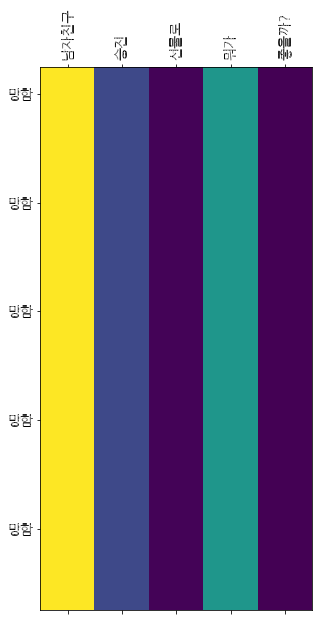

In [35]:
import matplotlib.pyplot as plt
query = "남자친구 승진 선물로 뭐가 좋을까?"

result, attention = evaluate(query)
translate(attention, query, result)